<a id='the_data'></a>
## Data overview

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected.

The training and test datasets provided here is a subset of these 43943 tweets.

The files to be downloaded are:
* **Train.csv** - the dataset for training our model.
* **Test.csv** - the dataset for testing our model .

Variable definitions on the train dataset:

`sentiment`: Sentiment of tweet

`message`: Tweet body

`tweetid`: Twitter unique ID

Each tweet is labelled as one of the following sentiment classes:

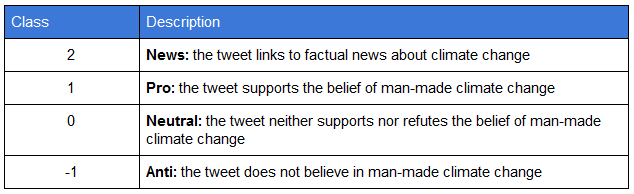

Before proceeding with importing the usual libraries, there are some natural language processing libraries that need to be installed: 

* `spacy`
* `wordcloud`
* `nltk`



In [1]:
!pip install spacy
!pip install wordcloud
!pip install nltk

In [2]:
#standard libraries
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

#modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.utils import resample

#text preprocessing libraries
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string

#pickling
import pickle

<a id='the_load'></a>
## Loading the datasets

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
train_data = pd.read_csv('train_set.csv')
test_data = pd.read_csv('test_set.csv')

In [5]:
#train_data = pd.read_csv('/kaggle/input/climate-change-belief-analysis/train.csv')
#test_data = pd.read_csv('/kaggle/input/climate-change-belief-analysis/test.csv')

<a id='inspecting'></a>
## Inspecting the data

In [6]:
train_data.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [7]:
test_data.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [8]:
len(train_data), len(test_data)

(33000, 5682)

The training set has 15819 tweets.

The testing set has 10546 tweets. 

For ease, the `tweetid` column is set to be the index. 

In [9]:

test_data.set_index('index', inplace=True)

Checking for missing data:

In [10]:
train_data.isnull().sum()

lang_id    0
text       0
dtype: int64

In [11]:
test_data.isnull().sum()

text    0
dtype: int64

Checking for empty strings:

In [12]:
blanks = []  # start with an empty list

for i,lb,tw in train_data.itertuples():  # iterate over the DataFrame
    if type(tw)==str:                    # avoid NaN values
        if tw.isspace():                 # test 'review' for whitespace
            blanks.append(i)             # add matching index numbers to the list
        
print(len(blanks), 'blanks in train data: ', blanks)   # Checking for empty strings

0 blanks in train data:  []


In [13]:
blanks = []  # start with an empty list

for i, tw in test_data.iterrows():  # iterate over the DataFrame
    if type(tw)==str:            # avoid NaN values
        if tw.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks in test data: ', blanks)

0 blanks in test data:  []


Th data has no missing values, and no empty tweet strings.

### **Noise Removal**

In [14]:
#Converting every tweet to be lower case
train_data['text'] = train_data['text'].str.lower()
test_data['text'] = test_data['text'].str.lower()

Here, unexpected artifacts, urls, twitter handles and numbers in the tweets are removed. 

In [15]:
def cleaning(text):
    
    """
    Function takes in a text, and returns it cleaned of all noise 
    (such as  unexpected artifacts, urls, twitter handles and numbers).
    
    """
    
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[\w]*','',text)
    text = re.sub(r'â€¦', '', text)
    text = re.sub(r'…', '', text)
    text = re.sub(r'â€™', "'", text)
    text = re.sub(r'â€˜', "'", text)
    text = re.sub(r'\$q\$', "'", text)
    text = re.sub(r'&amp;', "and", text)
    text = re.sub('[0-9]+', '', text)
    
    words = text.split()  
    
    return( " ".join(words))


In [16]:
train_data['text'] = train_data['text'].apply(cleaning)
test_data['text'] = test_data['text'].apply(cleaning)

Python's `string` library is used to remove punctuation.

In [17]:
def remove_punctuation(text):
    
    """custom function to remove the punctuation"""
    
    return text.translate(str.maketrans('', '', string.punctuation))

In [18]:
train_data['text'] = train_data['text'].apply(remove_punctuation)
test_data['text'] = test_data['text'].apply(remove_punctuation)

It is noticed that the tweets contain 'rt', implying a retweet.

Hence, 'rt', 'rts' and 'retweet' are added as stopwords, and all stopwords are now removed. 

In [19]:
#Remove Stop words
def stop(text):
    
    """" 
    Function takes in some text, adds the variants of 'retweets'
    into the stopwords list, and then removes all stopwords.
    
    """
    
    word = text.split()
    #Remove stop words
    stop_additional = ['rt','rts', 'retweet']
    stop_word = set().union(stopwords.words('english'), stop_additional)
    remove_stop = [w for w in word if w not in stop_word]
    free_stop = " ".join(remove_stop)
    
    return free_stop 


In [20]:
train_data['text'] = train_data['text'].apply(stop)
test_data['text'] = test_data['text'].apply(stop)

### Lexicon Normalization 

Another type of textual noise to be removed include multiple representations exhibited by a single word.

The common types of Lexicon Normalization:


* **Stemming**:  Stemming is a rudimentary rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s”, etc) from a word.
* **Lemmatization**: Lemmatization, on the other hand, is an organized, and step-by-step procedure of obtaining the root form of the word, by making use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In this case, lemmatization is chosen. In lemmatization, words like "loving", "lovely" and "loved" are normalized to their root-word "love".
This process returns words present in our dictionary; unlike stemming which may return words that may not even exist. 




In [21]:
def lemmatizer(text):
    
    """" 
    Function takes in some text, and returns the lemmatized text.
    
    """
    
    lemma = WordNetLemmatizer()
    new_text = " ".join([lemma.lemmatize(lem) for lem in text.split()])
    
    return new_text


In [22]:
train_data['text'] = train_data['text'].apply(lemmatizer)
test_data['text'] = test_data['text'].apply(lemmatizer)

[Feature engineering](https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering) on text data simply means extracting features from text using the following techniques:

* **Bag of Words** <br>
This extracts features from text and counts the frequency of words in a document (the simplest form). 
<br>
*  **TF-IDF** <br>
Tfidf combines **Term Frequency (TF)** and **Inverse Document Frequency** (IDF). It computes the term frequency-inverse document value for each word. TF is the raw count of a term in a document. IDF is an algorithm that reduces the weight for most common words and add more weight for words that are rare in a document. We compute these two as follows:
  * TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
  * IDF(t) = log_e(Total number of documents / Number of documents with term t in it) 
  <br>

* **Word2Vec** <br>
This is a two layer neutral-net that processes text.

This notebook makes use of the **TF-IDF** method.

Firstly, the data has to be split into labels and features. 

### Obtaining X and y

In [23]:
X = train_data['text']
y = train_data['lang_id'].values

The training data is now split up into the training dataset and the validation dataset.

### Splitting into training and validation sets

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Applying Tfidf

We now apply scikit-learn's `TfidfVectorizer` which does the following to our text data:

*   It counts all the occurrences of the unique words and transforms the tweets to feature vectors
*   A refinement on top of counting the words is to downscale the weight for words that occur in many tweets (such as "the") and are therefore less informative than those that occur only in a few tweets (such as "climate").
*   This is achieved by simply dividing the number of occurrences of each word in the tweets by the total number of words in the tweets.


In [25]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(26400, 125744)

Note the shape of `X_train_tfidf`, which indicates the number of features in the feature vector.

<a id='the_fit'></a>
## Modelling before resampling


**Models to Fit:**

1. **Logistic Regression**
   * Logistic Regression models the probability that `Y`(label) belongs to a certain category (or class). It uses the logistic       function to fit the model using the **maximum likelihood** method. It produces an `S-shaped` curve. This model         can be extended to Multi-class classification, where multiple logistic models can be combined using the          `one-vs-rest` approach.
<br>   


2. **Support Vector Machine**
   *  In classification, an SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on the side of the gap on which they fall.
   *  In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.
<br> 

 
3. **K-Nearest Neighbors (K-NN)**
   * K-NN is an easy and powerful machine learning algorithm. The algorithm works by assigning the majority class of the N-closest neighbors to the current data point. Hence, no training is required for the algorithm; the only thing that needs to be done is choosing the value of `k` (i.e. the number of neighbors to consider) and choose the Euclidean distance function (`minkowski`) to calculate proximity.<br>
  

### Modelling with default parameters

Remember that only the training set has been vectorized into a full vocabulary. In order to perform an analysis on the test set, it has to be submitted to the same procedures. Hence, the `Pipeline` class is used. 


In [34]:
def fit_evaluate_model(model, X_train, y_train):
    
    """ 
    Function takes a model to train as input, and returns the performance
    of said model (in the form of various metrics). 
    
    """
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf',model)])
    
    # Fit the model to the training set
    text_clf.fit(X_train, y_train) 
    
    # Obtain predictions on the training and validation set
    y_pred = text_clf.predict(X_train)
    y_pred_test=text_clf.predict(X_test)
    
    # Determining the performance of the model
    accuracy = accuracy_score(y_train,y_pred)
    precision = precision_score(y_train,y_pred,average='weighted')
    recall = recall_score(y_train,y_pred,average='weighted')
    f1 = f1_score(y_train,y_pred,average='weighted')
    f1_test = f1_score(y_test,y_pred_test,average='weighted')
    
    # Creating a dictionary for the metrics
    performance = {"accuracy": accuracy,"precision":precision,
                   "recall":recall,"f1_score":f1,"f1_test_score":f1_test}
    
    output = pd.DataFrame([performance])

 
    return output
    

#### Model 1 : Logistic Regression

In [27]:
model1 = LogisticRegression(max_iter=10000)
logistic_model = fit_evaluate_model(model1, X_train, y_train)

#### Model 2: Linear SVM model

In [28]:
model2 = LinearSVC()
linear_svc = fit_evaluate_model(model2, X_train, y_train)

#### Model 3 : Kernel SVM Model

In [29]:
model3 = SVC(kernel = 'rbf')
kernel_svc = fit_evaluate_model(model3, X_train, y_train)

#### Model 4 : K-NN Model

In [30]:
model4 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
k_nn = fit_evaluate_model(model4,X_train, y_train)

#### Assessing the performance

In [35]:
assess = pd.concat([logistic_model, linear_svc, kernel_svc, k_nn])
assess.index = ['Logistic Regression','Linear SVM Model','Kernel SVM Model', 'K-NN Model']
assess

,accuracy,precision,recall,f1_score,f1_test_score
Logistic Regression,0.999508,0.999508,0.999508,0.999508,0.995304
Linear SVM Model,1.000000,1.000000,1.000000,1.000000,0.997575
Kernel SVM Model,1.000000,1.000000,1.000000,1.000000,0.995915
K-NN Model,0.978977,0.979071,0.978977,0.978865,0.962653


The imbalance in our data can also be seen in the accuracy being significantly higher than the f1 score across all the models. 

The models' performance can now be improved through **hyperparametric tuning**.

<a id='submission'></a>
## Submissions to Kaggle

Submissions are now made to Kaggle to see the performance of the models on the true testing dataset. These F1-scores are the ones that carry the most weight.

In [39]:
def testing(model, filename, X, y):
    
    """" 
    Function takes a model, and X and y variables to train as input,
    and returns a csv file of predictions (named as "filename") to 
    submit to Kaggle in order to obtain the true F1-score. 
    
    """
    test_x = test_data['text']
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf',model)])
    
    # Fit the model to the training set
    text_clf.fit(X, y) 
    
    # Obtain predictions on the testing set
    y_pred = text_clf.predict(test_x)
    
    # Save predictions in a new DataFrame
    predictions = pd.DataFrame(y_pred, columns=['lang_id'], index = test_data.index)
    predictions.reset_index(inplace=True)
    
    return predictions.to_csv(filename+'.csv', index=False)

In [40]:
# return predictions.to_csv('/kaggle/working/'+filename+'.csv', index=False)

All the models built in this notebook are now evaluated according to the performance metric (The `F1-Score`) on the testing set:

### Models with default parameters

#### Logistic Regression: F1 Score = 0.73364

In [41]:
testing(model1, 'LogReg', X_train, y_train)

#### Linear SVC: F1 Score = 0.74834

In [42]:
testing(model2, 'LinearSVC', X_train, y_train)

#### Kernel SVM: F1 Score = 0.73577

In [43]:
testing(model3, 'KernelSVC', X_train, y_train)

#### K-NN: F1 Score = 0.64971

In [44]:
testing(model4, 'KNN', X_train, y_train)

### Models with tuned hyperparameters

#### Logistic Regression: F1 Score = 0.75225

In [45]:
testing(LogisticRegression(C=6.0, max_iter=10000), 'LogReg_Tuned', X_train, y_train)

#### Kernel SVM: F1 Score = 0.75651

In [ ]:
testing(SVC(kernel='rbf', C=100, gamma='scale'), 'KernelSVC_Tuned', X_train, y_train)

#### K-Nearest Neighbours: F1 Score = 0.65259

In [ ]:
testing(KNeighborsClassifier(leaf_size=20, n_neighbors=9), 'KNN_Tuned', X_train, y_train)

### Models with resampled data

#### Logistic Regression: F1 Score = 0.65483

<a id='the_eval'></a>
## Evaluating the models

Now we evaluate the performance of all the models:

In [ ]:
def the_fit(model):
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', model)])

    # Feed the training data through the pipeline
    return text_clf.fit(X_train, y_train) 
    

In [ ]:
# The best model
best_model = SVC(kernel='rbf', C=100, gamma='scale')
kernel_svc = the_fit(best_model)

In [ ]:
model = kernel_svc 
model_save_path = "model_1.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)